In [2]:
import pandas as pd
from ggplot import *

project_id = "the-d-team-164512"

Based on the most popular drugs by count, I found the ATC level 5 code and found all the transactions for that code. The codes are:

    'C10AA07', 'N02BE01', 'C10AA05', 'A02BC05', 'C09AA04', 'C09CA07', 'R03BB04', 'C07AB03', 'C09CA06', 'A02BC02'

In [7]:
query = """\
SELECT
  d.ATCLevel5Code AS ATC_5_code
  , a.ATCLevel5Name AS ATC_5_name
  , DATE(STRFTIME_UTC_USEC(DATE(t.Dispense_Week), "%Y-%m-01")) AS year_month
  , SUM(pcd.distance) AS sum_distance
  , SUM(t.PatientPrice_Amt) AS sum_price
  , count(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
JOIN dthon.patients_lookup p
ON t.patient_id = p.patient_id
JOIN dthon.stores_lookup s
ON s.store_id = t.store_id
JOIN dthon.postcode_distances pcd
ON p.postcode = pcd.from_postcode AND s.postcode = pcd.to_postcode
JOIN dthon.atc_lookup a
ON a.ATCLevel5Code = d.ATCLevel5Code
WHERE
  d.ATCLevel5Code IN ('C10AA07', 'N02BE01', 'C10AA05', 'A02BC05', 'C09AA04', 'C09CA07', 'R03BB04', 'C07AB03', 'C09CA06', 'A02BC02')
GROUP BY
  ATC_5_code
  , ATC_5_name
  , year_month
ORDER BY
  ATC_5_code
  , year_month ASC
"""

df_pop = pd.read_gbq(query, project_id)
df_pop.year_month = pd.Series(df_pop.year_month).apply(pd.to_datetime, format='%Y-%m')
df_pop.head(3)

Waiting for job to complete...
Waiting for job to complete...


,ATC_5_code,ATC_5_name,year_month,sum_distance,sum_price,transaction_count
0,A02BC02,PANTOPRAZOLE,2010-12-01,1951.415201,431.13,37
1,A02BC02,PANTOPRAZOLE,2011-01-01,655120.404133,183076.65,19643
2,A02BC02,PANTOPRAZOLE,2011-02-01,523389.154006,162517.40,17628


## Distance
Contrary to findings in analysis/Lipitor_replacement.ipynb which suggest such an extra distance to travel for generics that it suggested something wrong with the data. Here the distance across all most popular drugs is pretty constant. This suggests that the distance calculations are ok?

Interesting thing is the peak in distnace during Australian winters?
* what could this be due to?
* how can we confirm this data is correct?

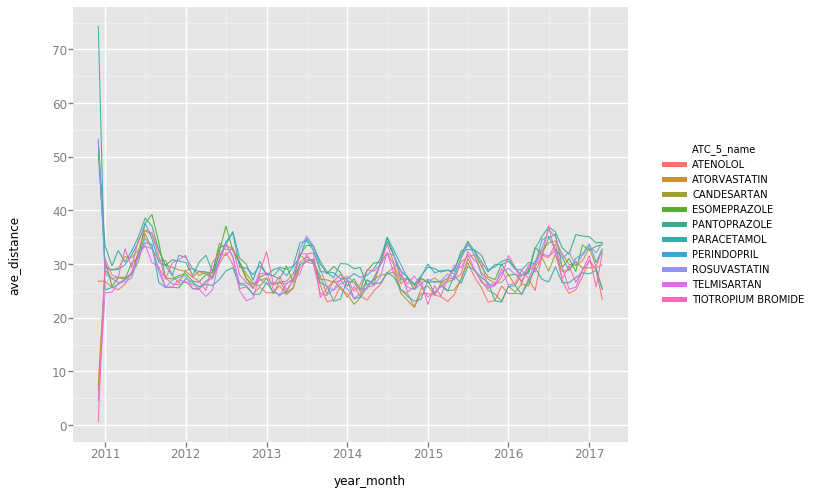

<ggplot: (279920490)>

In [12]:
df_pop['ave_distance'] = df_pop.sum_distance / df_pop.transaction_count
ggplot(
    aes(x='year_month', y='ave_distance', colour='ATC_5_name'),
    data=df_pop) +\
    geom_line()

## Average Price
This data looks so wrong. How can there be a drop each year in the average patient price by transaction count? there has to be something wrong in my logic here?

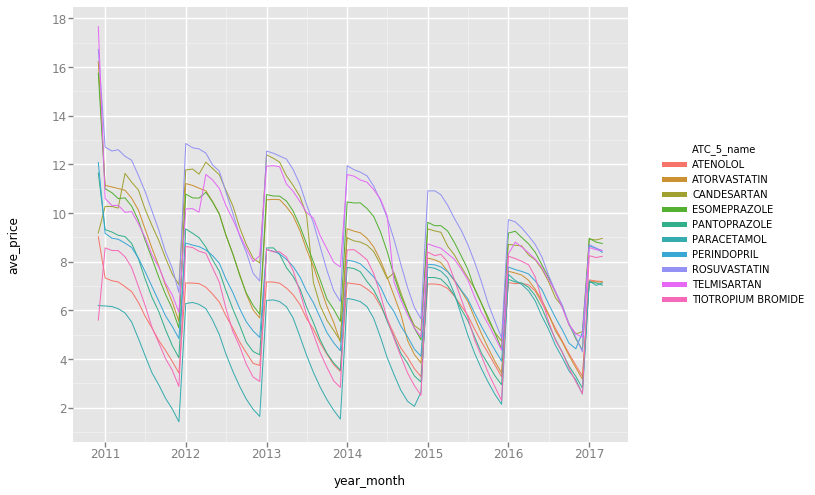

<ggplot: (281986522)>

In [13]:
df_pop['ave_price'] = df_pop.sum_price / df_pop.transaction_count
ggplot(
    aes(x='year_month', y='ave_price', colour='ATC_5_name'),
    data=df_pop) +\
    geom_line()